In [127]:
import warnings

In [128]:
!pip install graphviz

In [274]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
#from lightgbm import LGBMRegressor

#import lazypredict
#from lazypredict.Supervised import LazyRegressor

from dtreeviz.trees import * #plotting decision trees
#from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score, plot_roc_curve 
#from tdc.single_pred import ADME
from sklearn.metrics import roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import math 
from tqdm import tqdm

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors




In [130]:
desc=pd.DataFrame(Descriptors._descList)

In [131]:
data= pd.read_csv("/Users/ajaniharesh/Desktop/MLTest/Solublity/data_cleaned.csv")
data

Unnamed: 0 Compound ID                     InChIKey  \
0            294       C1951  NZFNXWQNBYZDAQ-UHFFFAOYSA-N   
1            295       C1952  CIMQMKORBAJNEC-UHFFFAOYSA-N   
2            296       C1953  MOPIFNSMNXBREW-UHFFFAOYSA-N   
3            297       C1954  CKHJPWQVLKHBIH-ZDSKVHJSSA-N   
4            298       C1955  NAPSCFZYZVSQHF-UHFFFAOYSA-N   
...          ...         ...                          ...   
9637        9937       C9943  OGGXGZAMXPVRFZ-UHFFFAOYSA-N   
9638        9938       C1664  QTBSBXVTEAMEQO-UHFFFAOYSA-N   
9639        9939       C1665  HDZGCSFEDULWCS-UHFFFAOYSA-N   
9640        9940       C1666  OKKJLVBELUTLKV-UHFFFAOYSA-N   
9641        9941       C1667  DLFVBJFMPXGRIB-UHFFFAOYSA-N   

                                                 SMILES      logS    logP  \
0              CSc1ccc2c(c1)N(CCC1CCCCN1C)c1ccccc1S2.Cl -7.489054  6.6905   
1     CC(=O)OCCN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc... -7.487043  6.4237   
2                          CCCCCCCNc1c2ccccc2nc2ccccc12 -7.477457  5.8433   
3     C/C(=C(\CCOC(=O)C(C)C)SS/C(CCOC(=O)C(C)C)=C(/C... -7.466676  7.1220   
4                               CCCCCCCCCCCCCCCCCCN(C)C -7.455306  6.8095   
...                                                 ...       ...     ...   
9637                                      C[As](C)(=O)O  1.161157  0.1110   
9638                                            CC(=O)O  1.220000  0.0909   
9639                                                CNN  1.340000  0.1707   
9640                                                 CO  1.570000 -0.3915   
9641                                            CC(N)=O  1.580000  0.1919   

            MW  
0     407.0350  
1     552.4800  
2     292.4180  
3     702.8880  
4     297.5620  
...        ...  
9637  137.9970  
9638   60.0520  
9639   46.0717  
9640   32.0419  
9641   59.0672  

[9642 rows x 7 columns]

In [132]:
data=data[['Compound ID','SMILES','logS','logP']]
data

Compound ID                                             SMILES      logS  \
0          C1951           CSc1ccc2c(c1)N(CCC1CCCCN1C)c1ccccc1S2.Cl -7.489054   
1          C1952  CC(=O)OCCN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc... -7.487043   
2          C1953                       CCCCCCCNc1c2ccccc2nc2ccccc12 -7.477457   
3          C1954  C/C(=C(\CCOC(=O)C(C)C)SS/C(CCOC(=O)C(C)C)=C(/C... -7.466676   
4          C1955                            CCCCCCCCCCCCCCCCCCN(C)C -7.455306   
...          ...                                                ...       ...   
9637       C9943                                      C[As](C)(=O)O  1.161157   
9638       C1664                                            CC(=O)O  1.220000   
9639       C1665                                                CNN  1.340000   
9640       C1666                                                 CO  1.570000   
9641       C1667                                            CC(N)=O  1.580000   

        logP  
0     6.6905  
1     6.4237  
2     5.8433  
3     7.1220  
4     6.8095  
...      ...  
9637  0.1110  
9638  0.0909  
9639  0.1707  
9640 -0.3915  
9641  0.1919  

[9642 rows x 4 columns]

In [133]:
#Add a new column "IsSol" to indicate whether a molecule's solubility is greater than 200uM
data['IsSol']= data.logS > math.log10(200 * 1e-6)

/var/folders/05/1c70fqnn7xn75w5t6t36d1tw0000gn/T/ipykernel_11665/3633924808.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['IsSol']= data.logS > math.log10(200 * 1e-6)


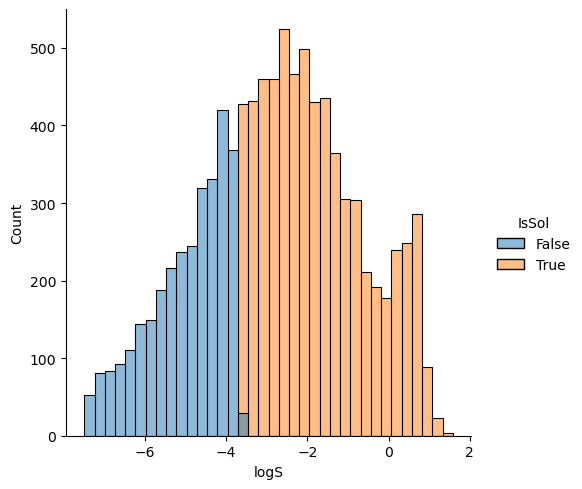

In [134]:
sns.displot(x='logS',hue="IsSol", data=data)

In [ ]:
#Calculate RDkit Molecular Descriptors, which are molecular features

def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] 
                                    for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in tqdm(mols):
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(data['SMILES'])


  0%|                                                  | 0/9642 [00:00<?, ?it/s][21:53:14] DEPRECATION WARNING: please use MorganGenerator
[21:53:14] DEPRECATION WARNING: please use MorganGenerator
[21:53:14] DEPRECATION WARNING: please use MorganGenerator
[21:53:14] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 42 in file /Users/runner/miniforge3/conda-bld/rdkit_1721395896353/work/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
****

[21:53:14] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 42 in file /Users/runner/miniforge3/conda-bld/rdkit_1721395896353/work/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
****

[21:53:14] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 42 in file /Users/runner/miniforg

In [138]:
# Put the descriptors to dataframe
Dataset_with_210_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
Dataset_with_210_descriptors.head()

MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0           9.248513        9.248513           0.047749       -4.679535   
1          14.362454       14.362454           0.000734       -5.721682   
2           8.718980        8.718980           0.553267       -4.553416   
3          13.834148       13.834148           0.860405       -5.292492   
4           8.297275        8.297275           1.264232       -5.381834   

        qed        SPS    MolWt  HeavyAtomMolWt  ExactMolWt  \
0  0.548454  46.961538  407.048         379.832  406.130419   
1  0.409225  36.200000  552.490         522.250  551.138788   
2  0.441432  31.454545  292.426         268.234  292.193949   
3  0.116163  30.500000  702.904         656.536  702.298173   
4  0.266497  55.190476  297.571         254.227  297.339550   

   NumValenceElectrons  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0                  140  ...           1             0           0   
1                  194  ...           0             0           0   
2                  114  ...           0             0           0   
3                  262  ...           0             0           0   
4                  128  ...           0             0           0   

   fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  \
0                  0             0            0            0             0   
1                  0             0            0            0             0   
2                  0             0            0            0             0   
3                  0             0            0            0             0   
4                  0             0            0            0             0   

   fr_unbrch_alkane  fr_urea  
0                 0        0  
1                 0        0  
2                 0        0  
3                 0        0  
4                 0        0  

[5 rows x 210 columns]

In [142]:
Dataset_with_210_descriptors.shape

(9642, 210)

In [141]:
Dataset_with_210_descriptors.to_csv("RDKit-210-descriptors.csv")

In [150]:
data1=Dataset_with_210_descriptors[['MolWt','NumHAcceptors','NumHDonors','MolLogP']]
data1

MolWt  NumHAcceptors  NumHDonors  MolLogP
0     407.048              4           0  6.30740
1     552.490              6           0  5.72250
2     292.426              2           1  5.77030
3     702.904             14           2  4.68784
4     297.571              1           0  6.80950
...       ...            ...         ...      ...
9637  137.998              2           1  0.11100
9638   60.052              2           1  0.09090
9639   46.073              2           2 -0.92050
9640   32.042              1           1 -0.39150
9641   59.068              1           1 -0.50840

[9642 rows x 4 columns]

In [152]:
combine=pd.concat([data, data1], axis=1)

In [155]:
combine

Compound ID                                             SMILES      logS  \
0          C1951           CSc1ccc2c(c1)N(CCC1CCCCN1C)c1ccccc1S2.Cl -7.489054   
1          C1952  CC(=O)OCCN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc... -7.487043   
2          C1953                       CCCCCCCNc1c2ccccc2nc2ccccc12 -7.477457   
3          C1954  C/C(=C(\CCOC(=O)C(C)C)SS/C(CCOC(=O)C(C)C)=C(/C... -7.466676   
4          C1955                            CCCCCCCCCCCCCCCCCCN(C)C -7.455306   
...          ...                                                ...       ...   
9637       C9943                                      C[As](C)(=O)O  1.161157   
9638       C1664                                            CC(=O)O  1.220000   
9639       C1665                                                CNN  1.340000   
9640       C1666                                                 CO  1.570000   
9641       C1667                                            CC(N)=O  1.580000   

        logP  IsSol    MolWt  NumHAcceptors  NumHDonors  MolLogP  
0     6.6905  False  407.048              4           0  6.30740  
1     6.4237  False  552.490              6           0  5.72250  
2     5.8433  False  292.426              2           1  5.77030  
3     7.1220  False  702.904             14           2  4.68784  
4     6.8095  False  297.571              1           0  6.80950  
...      ...    ...      ...            ...         ...      ...  
9637  0.1110   True  137.998              2           1  0.11100  
9638  0.0909   True   60.052              2           1  0.09090  
9639  0.1707   True   46.073              2           2 -0.92050  
9640 -0.3915   True   32.042              1           1 -0.39150  
9641  0.1919   True   59.068              1           1 -0.50840  

[9642 rows x 9 columns]

In [167]:
desc_cols = ['MolWt','NumHAcceptors','NumHDonors','MolLogP']

In [168]:
#Split the data into training and test sets.
train, test = train_test_split(combine)

In [169]:
train

Compound ID                                             SMILES      logS  \
5085        C853                                          C1=CCCCC1 -2.590000   
7637       C8260  COc1ccc2cc3[n+](cc2c1OC)CCc1cc2c(cc1-3)OCO2.CO... -1.123880   
6222       C7135             O=C1C2C3CCC(O3)C2C(=O)N1c1ccc(Cl)cc1Cl -2.010058   
182        C2096     CC(Cc1ccccc1)NCC1CCC(CNC(C)Cc2ccccc2)CC1.Cl.Cl -6.826017   
6574       C7411                       Cl.Nc1ccc(C(=O)Nc2cccnc2)cc1 -1.811954   
...          ...                                                ...       ...   
3003       C4484                              CC(=O)O.CCCCCCCCCCCCN -3.735710   
4173       C5452                    COc1ccc(CN(CCN(C)C)c2ccccn2)cc1 -3.066274   
5499       C6542  Cc1cc2c(O)c3c(=O)ccoc3c(OCC(O)C[NH2+]C(C)C)c2o... -2.377307   
8360       C8837          CCC(=O)C(CC(C)N(C)C)(c1ccccc1)c1ccccc1.Cl -0.459783   
5660       C6667              NC(=O)OCCN1Cc2ccc([N+](=O)[O-])cc2CO1 -2.299798   

        logP  IsSol    MolWt  NumHAcceptors  NumHDonors  MolLogP  
5085  2.1166   True   82.146              0           0  2.11660  
7637  5.9354   True  768.797             12           0  4.85460  
6222  2.7252   True  312.152              3           0  2.66020  
182   7.6202  False  451.526              2           2  6.07800  
6574  3.3723   True  249.701              3           2  2.33790  
...      ...    ...      ...            ...         ...      ...  
3003  4.6572  False  245.407              3           2  3.95690  
4173  2.6584   True  285.391              4           0  2.65840  
5499 -1.7313   True  383.828              6           3 -1.73128  
8360  5.0940   True  345.914              2           0  4.71380  
5660  2.0987   True  267.241              6           1  0.93730  

[7231 rows x 9 columns]

In [170]:
test

Compound ID                                             SMILES      logS  \
785        C2619  CCC(CC)CCN1CC[C@]23CCCC[C@H]2[C@H]1Cc1ccc(O)cc... -5.623448   
5539        C944               C=CCC1([C@@H](C)CCC)C(=O)NC(=O)NC1=O -2.360000   
1930       C3581                   CCCN1CCC(OC(=O)Nc2c(C)cccc2C)CC1 -4.458686   
2841       C4352                     O=C1C(Br)=C(Br)C(=O)C(Br)=C1Br -3.842421   
1100       C2894  COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CCCOc2ccc(F)cc2)C... -5.235851   
...          ...                                                ...       ...   
470        C2340  COC(=O)[C@H]1[C@H]2C[C@@H]3c4[nH]c5cc(OC)ccc5c... -6.124341   
8550       C8992                                        CC1(C)NCCS1 -0.225732   
7171       C7893                       NC(=O)c1cccc([N+](=O)[O-])c1 -1.461023   
6717       C1162                              CC(=O)Oc1ccccc1C(=O)O -1.720000   
7229       C7942                               CNC(C)(C)C(C)(C)C.Cl -1.424151   

        logP  IsSol    MolWt  NumHAcceptors  NumHDonors  MolLogP  
785   3.0922  False  491.625              8           5  3.15430  
5539  2.0087   True  238.287              3           2  1.35110  
1930  3.7372  False  290.407              3           1  3.72634  
2841  3.1410  False  423.680              2           0  3.14100  
1100  4.2681  False  465.953              6           2  3.35810  
...      ...    ...      ...            ...         ...      ...  
470   4.5086  False  634.726             10           1  4.57070  
8550  1.3877   True  117.217              2           1  1.05890  
7171  1.9172   True  166.136              3           1  0.69370  
6717  1.3101   True  180.159              4           1  1.31010  
7229  3.2234   True  165.708              1           1  2.45230  

[2411 rows x 9 columns]

In [228]:
#Create and train a classifier

cls = DecisionTreeClassifier(max_depth=2)
cls.fit(train_X,train_y)

DecisionTreeClassifier(max_depth=2)

In [229]:
#Predict on the test set
pred = cls.predict(test_X)
auc, mcc, kappa = roc_auc_score(test_y, pred),matthews_corrcoef(test_y,pred),cohen_kappa_score(test_y,pred)
print(f"ROC AUC = {auc:.2f}")
print(f"Matthews Correlation Coefficient = {mcc:.2f}")
print(f"Cohen\'s Kappa = {kappa:.2f}")

ROC AUC = 0.79
Matthews Correlation Coefficient = 0.63
Cohen's Kappa = 0.62


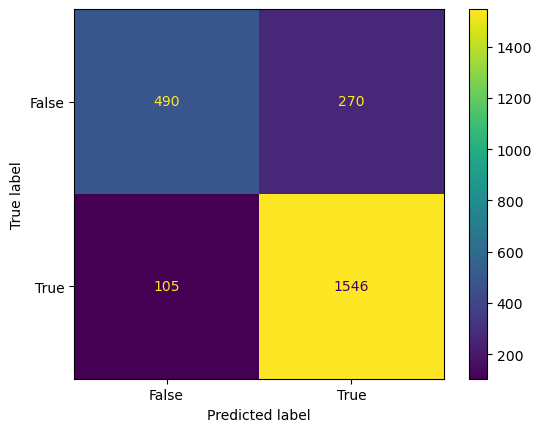

In [230]:
#Plot a confusion matrix to show the classifier performance
ConfusionMatrixDisplay.from_estimator(cls,test_X,test_y)

In [238]:
from sklearn.metrics import RocCurveDisplay

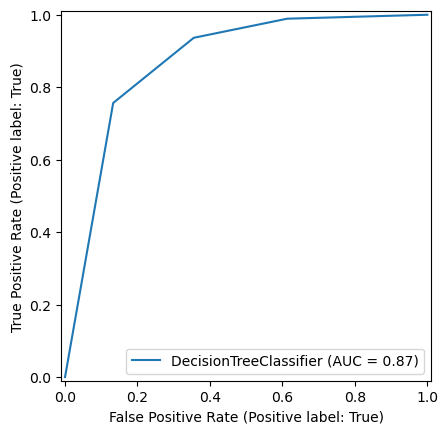

In [239]:
#Plot an ROC cure to show the classifier performance
RocCurveDisplay.from_estimator(cls,test_X,test_y)

[Text(0.5, 0.8333333333333334, 'MolLogP <= 3.275\ngini = 0.435\nsamples = 7231\nvalue = [2307, 4924]'),
 Text(0.25, 0.5, 'MolWt <= 316.426\ngini = 0.263\nsamples = 5404\nvalue = [843, 4561]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.135\nsamples = 3978\nvalue = [289, 3689]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.475\nsamples = 1426\nvalue = [554, 872]'),
 Text(0.75, 0.5, 'MolLogP <= 4.146\ngini = 0.318\nsamples = 1827\nvalue = [1464, 363]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.433\nsamples = 918\nvalue = [627, 291]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.146\nsamples = 909\nvalue = [837, 72]')]

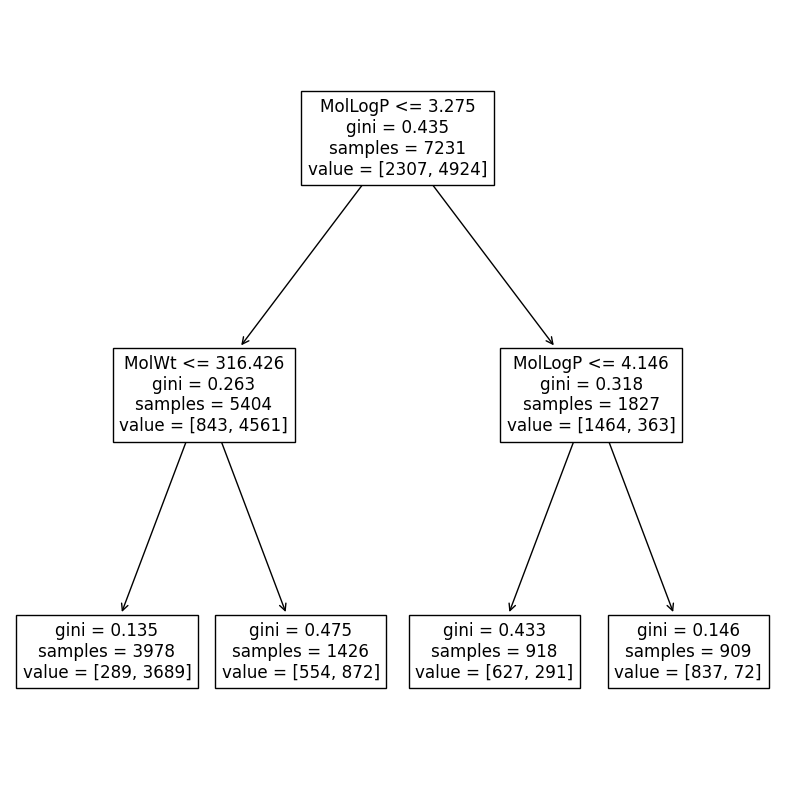

In [271]:
#Use the default view from SciKit Learn to plot the decision tree

plt.rcParams["figure.figsize"] = (10,10)
plot_tree(cls,feature_names=desc_cols)